## Adaptive Filter Attention

### Setup

In [1]:
import numpy as np
import math
import scipy

from matplotlib import pyplot as plt
import matplotlib.cm as cm
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('font', size=20)

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import transformers
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
# from collections import Counter

import os
import argparse
import time
from tqdm import tqdm # Loading bar
print('Done.')

Done.


In [2]:
from utils import complex_conj_transpose, batched_complex_conj_transpose, complex_exp, complex_exp_v2, complex_hadamard, complex_matmul, complex_division
from utils import batched_complex_conj_transpose, batched_complex_hadamard, batched_complex_matmul, batched_complex_division
from utils import batched_complex_exp, batched_complex_hadamard_full, batched_complex_matmul_full
from utils import to_complex
print('Done.')

Done.


In [3]:
from misc import f_pij_scalar
from misc import construct_2D_rotation_matrix, construct_2D_unitary_matrix, construct_special_2D_unitary, construct_diag_matrix, construct_2D_normal_matrix, orthogonal_matrix_2D
print('Done')

Done


In [4]:
from dynamics import stochastic_LTI, DynamicSim
from dynamics import construct_mapping
from dynamics import get_nth_measurement, get_random_measurements
from dynamics import linear_spiral, linear_spiral_3D, Lorenz, rand_coupling_matrix, Van_der_Pol_osc
print('Done.')

Done.


In [5]:
from precision_attention import compute_residuals, compute_kernel_v1, compute_estimates_and_residuals_vectorized, get_time_diffs, compute_neg_kernel, clamp_exponent_arg
from precision_attention import compute_exp_kernel, batched_compute_estimates_and_residuals_vectorized, compute_estimates_and_residuals_irregular_times
from precision_attention import compute_precision_v1
# from precision_attention import precise_attn, precise_attn_with_correction, precise_attn_full
from precision_attention import compute_precision, compute_precision_tanh
from precision_attention import compute_covariance_kernel, compute_covariance_kernel_tanh, build_covariance_from_kernel, build_avg_covariance_from_kernel
from precision_attention import build_factorized_kernels, compute_residual_norm, compute_weighted_residual_norm
print('Done.')

Done.


In [6]:
from model import compute_lambda_h
from model import init_complexlinear, init_complex_matrix, build_nearly_identity
from model import initialize_to_correct_model, initialize_net_to_correct_model
from model import init_weight_masks, apply_weight_masks
from model import Complex_MSE_Loss, Batched_Complex_MSE_Loss
from model import inverse_penalty, inverse_net_penalty, lambda_L1_penalty
from model import ComplexLinearLayer, AttentionLayer, ComplexAttentionLayer
from model import ModReLU
from model import GatedSequenceNorm, GatedLayerNorm, GatedComplexSequenceNorm, GatedComplexLayerNorm
from model import TransformerBlock, ComplexTransformerBlock, ComplexRealTransformerBlock
from model import Attention_1layer, ComplexAttention_1layer
from model import SimpleAttention_Net, SimpleComplexAttention_Net, SimpleComplexRealAttention_Net
from model import TransformerNetwork, ComplexTransformerNetwork, ComplexRealTransformerNetwork
from model import FullPrecisionAttentionBlock
from model import FullPrecisionAttentionBlockShared, FullPrecisionAttentionBlock_Nlayer
from model import AFA_1layer, AFA_Nlayer, AFATransformerBlock, AFATransformerNetwork

print('Done.')

Done.


In [7]:
from data_utils import construct_random_mapping, construct_data, TrainDataset, create_train_loader
print('Done.')

Done.


In [8]:
from visualization import plot_trajectory, compute_state_transition_matrix, plot_state_transition_matrix, plot_eigenvals, visualize_results
from visualization import visualize_results_attn
print('Done.')

Done.


In [9]:
from training import single_iter, single_epoch, hook_fn
from training import single_iter_attn, single_epoch_attn
print('Done.')

Done.


In [10]:
# import utils
# import misc
# import dynamics
# import precision_attention
# import model
# import data_utils
# import visualization
# import training

# print('Done.')

In [11]:
parser = argparse.ArgumentParser('DA')
parser.add_argument('--gpu', type=int, default=0) # (Default: 0)
args = parser.parse_args(args=[])
args.device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
print(args.device)

torch.manual_seed(2025)
np.random.seed(2025)

cuda:0


### Training

In [12]:
# Set dynamical system

# # Normal system
# D1 = torch.zeros(2,2,2).to(args.device) # Diagonal matrix
# D1[0] = torch.tensor([[-0.1, 0.0], [0.0, -0.1]]).to(args.device)
# D1[1] = torch.tensor([[-1.0, 0.0], [0.0, 1.0]]).to(args.device)
# # S1 = torch.zeros(2,2,2).to(args.device)
# # S1[0] = torch.tensor(([1.0,1.0],[0.0,0.0]))
# # S1[1] = torch.tensor(([0.0,0.0],[1.0,-1.0]))
# # S1 = U/np.sqrt(2)
# alpha = np.random.uniform(low=0.0, high=1.0)*2*np.pi
# beta = np.random.uniform(low=0.0, high=1.0)*2*np.pi
# S1 = construct_special_2D_unitary(alpha=alpha, beta=beta)
# Si1 = complex_conj_transpose(S1)

# Stable 2D linear system (in diagonalized form):
D1 = torch.zeros(2,2,2).to(args.device) # Diagonal matrix
S1 = torch.zeros(2,2,2).to(args.device) # RHS matrix
Si1 = torch.zeros(2,2,2).to(args.device) # Inverse of RHS matrix
D1[0] = torch.tensor([[-0.1, 0.0], [0.0, -0.1]]).to(args.device)
D1[1] = torch.tensor([[-1.0, 0.0], [0.0, 1.0]]).to(args.device)
# D1[0] = torch.tensor([[-0.1, 0.0], [0.0, -0.5]]).to(args.device)
# D1[1] = torch.tensor([[-0.0, 0.0], [0.0, 0.0]]).to(args.device)
S1[0] = torch.tensor([[1.0, 1.0], [1.0, 1.0]]).to(args.device)
S1[1] = torch.tensor([[-1.0, 1.0], [0.0, 0.0]]).to(args.device)
Si1[0] = 0.5*torch.tensor([[0.0, 1.0], [0.0, 1.0]]).to(args.device)
Si1[1] = 0.5*torch.tensor([[1.0, -1.0], [-1.0, 1.0]]).to(args.device)
A = complex_matmul(S1,complex_matmul(D1,Si1))[0].unsqueeze(0)
params = [D1, S1, Si1]

In [13]:
# DEFINE MODEL

args.cr_max = 2
args.cr_min = 0

args.t_equal = 1 # Equal time intervals? (0 or 1)
args.sep_params = 0 # Use separate params for keys and values? (0 or 1)
args.rand_embed = 1 # Use random orthogonal matrix when projecting data to higher dimension?
args.weight_mask = 0 # Mask the weights? (0 or 1)

args.complex_loss = 0 # Apply loss to both real and complex parts of output? (0 or 1)
args.inverse_penalty_weight = 0.0 # Inverse penalty weight
args.L1_penalty_weight = 0.0 # L1 penalty weight on lambda1
args.tanh = 0 # Use tanh (i.e. Ricatti equation rather than Lyapunov)? (0 or 1)
args.momentum = 1 # Use momentum update for AFA layers of depth > 1? (0 or 1)

args.m = 2 # Dimension of simulated system
# args.embed_dim = 2 # Embedding dimension
args.d_e = 128 # Embedding dimension

# args.num_heads = 1
# args.head_dim = int(args.embed_dim/args.num_heads)

#######################################

# Key, query, value embedding dimensions are same as input embedding dimension
args.d_k = args.d_e
args.d_v = args.d_e
# args.d_k = args.head_dim
# args.d_v = args.head_dim

# # Key, query, value embedding dimensions are half of input embedding dimension
# args.d_k = int(args.head_dim/2) # Key and query embedding dimension
# args.d_v = int(args.head_dim/2) # Value embedding dimension

# # Key, query, value embedding dimensions are 2
# args.d_k = 2 # Key and query embedding dimension
# args.d_v = 2 # Value embedding dimension

#######################################

args.nu = 1.0 # Measurement weighting
args.tf = 10.0 # Final time
args.dt = 0.01 # Time step size
args.n = 10 # nth measurement (ie use every nth point as a measurement)

args.N_t = int(args.tf/args.dt) # Number of time steps
args.seq_len = int(args.N_t/args.n) # Number of measurements
# t_v = (torch.arange(args.N_t + args.n)*args.dt).to(args.device) # Array of time steps
t_v = (torch.arange(args.N_t + args.n)*args.dt).to(args.device) # Array of time steps

# Some scalar weights in model
args.alpha = 1.0
args.beta = 0.0
args.delta = 1.0
args.eta = 0.0

# DEFINE MODEL:

###########################################################

# Vanilla Attention Models

# args.model_type = 'RealInputs'
# model = Attention_1layer(args.d_e, args.d_v, args).to(args.device)
# model = SimpleAttention_Net(args.d_e, args.d_v, args).to(args.device)
# # model = TransformerNetwork(args.d_e, args.d_v, args, num_blocks=2).to(args.device)
# loss = nn.MSELoss()

###########################################################

# Complex Attention Models

# args.model_type = 'ComplexInputs'
# # args.norm_type = 'LayerNorm'
# args.norm_type = 'SequenceNorm'
# # args.norm_type = None
# # args.metric = 'RealDotProduct'
# # args.metric = 'MagDotProduct'
# args.metric_type = 'InverseMahalanobis'
# # model = ComplexAttention_1layer(args.d_e, args.d_v, args, num_blocks=1).to(args.device)
# model = SimpleComplexAttention_Net(args.d_e, args.d_v, args).to(args.device)
# # model = ComplexTransformerNetwork(args.d_e, args.d_v, args, num_blocks=2).to(args.device)
# loss = Batched_Complex_MSE_Loss() # Loss
# loss_p = Complex_MSE_Loss() # Frobenius Norm Penalty

###########################################################

# # Complex Attention with Real Input/Output Models

# args.model_type = 'RealInputs'
# # args.metric = 'RealDotProduct'
# # args.metric = 'MagDotProduct'
# args.metric_type = 'InverseMahalanobis'
# # model = SimpleComplexRealAttention_Net(args.d_e, args.d_v, args).to(args.device)
# model = ComplexRealTransformerNetwork(args.d_e, args.d_v, args, num_blocks=2).to(args.device)
# loss = nn.MSELoss()

###########################################################

# # Precision Attention Models

# # args.model_type = 'ComplexInputs'
# args.model_type = 'RealInputs'
# # model = FullPrecisionAttentionBlock(args).to(args.device)
# # model = PrecisionNet_1layer(args).to(args.device)
# args.num_layers = 1
# # model = FullPrecisionAttentionBlock_Nlayer(args.d_e, args.d_k, args.d_v, args.num_layers, args).to(args.device)
# model = AFA_Nlayer(args).to(args.device)
# # loss = Batched_Complex_MSE_Loss() # Loss
# loss = nn.MSELoss()
# loss_p = Complex_MSE_Loss() # Frobenius Norm Penalty

###########################################################

# AFA Transformers

# args.model_type = 'ComplexInputs'
args.model_type = 'RealInputs'
args.num_inner_layers = 1
args.num_blocks = 1
# model = AFATransformerBlock(args.d_e, args.d_k, args.d_v, args.num_inner_layers, args).to(args.device)
model = AFATransformerNetwork(args.d_e, args.d_k, args.d_v, args, args.num_inner_layers, args.num_blocks).to(args.device)
# loss = Batched_Complex_MSE_Loss() # Loss
loss = nn.MSELoss()
loss_p = Complex_MSE_Loss() # Frobenius Norm Penalty

###########################################################

params_list = list(model.parameters()) # Parameters list

Pu, Pd, R1, R1i = construct_random_mapping(S1, Si1, args) # Get random matrices

# loss_p = Complex_Trace_Loss() # Trace Penalty
lr = 1E-2 # Learning rate
optimizer = torch.optim.Adam(params_list, lr=lr, betas=(0.9, 0.999)) # Optimizer

if args.d_k != args.d_v and args.sep_params == 0:
    print('ERROR: Key and value embedding dimensions must be the same if using shared parameters.')

In [14]:
## CREATE TRAINING DATA

# Training params
args.num_epochs = 1000 # Number of epochs
args.num_samp = 32 # Number of samples in train loader
args.batch_size = 32 # Batch size
args.num_its = int(args.num_samp/args.batch_size) # Number of iterations in an epoch
args.save_epochs = 1 # Intervals of epochs to save model
args.show_example_epochs = 5 # Number of epochs between displaying results so far
args.n_example = 5 # Plot state estimates at n_example data points
args.epsilon = 1E-5

# Process and measurement noise:
sigma_process = 0.0 # Process noise
# sigma_process = 0.2 # Process noise
# sigma_measure = 0.1 # Measurement noise
# sigma_measure = 1.0 # Measurement noise
sigma_measure = 2.0 # Measurement noise

#####################################################################

# Iniitialize arrays to record losses
mean_epoch_losses = np.zeros(args.num_epochs)
log_mean_epoch_losses = np.zeros(args.num_epochs)
all_losses = np.zeros(args.num_epochs * args.num_samp)
all_lambdas = np.zeros((args.num_epochs, 2, args.d_v))

# Build training dataset
train_loader, train_dataset, X_true_all, X_measure_all, t_measure_all = create_train_loader(A, S1, Si1, Pu, Pd, R1, R1i, t_v, sigma_process, sigma_measure,args)

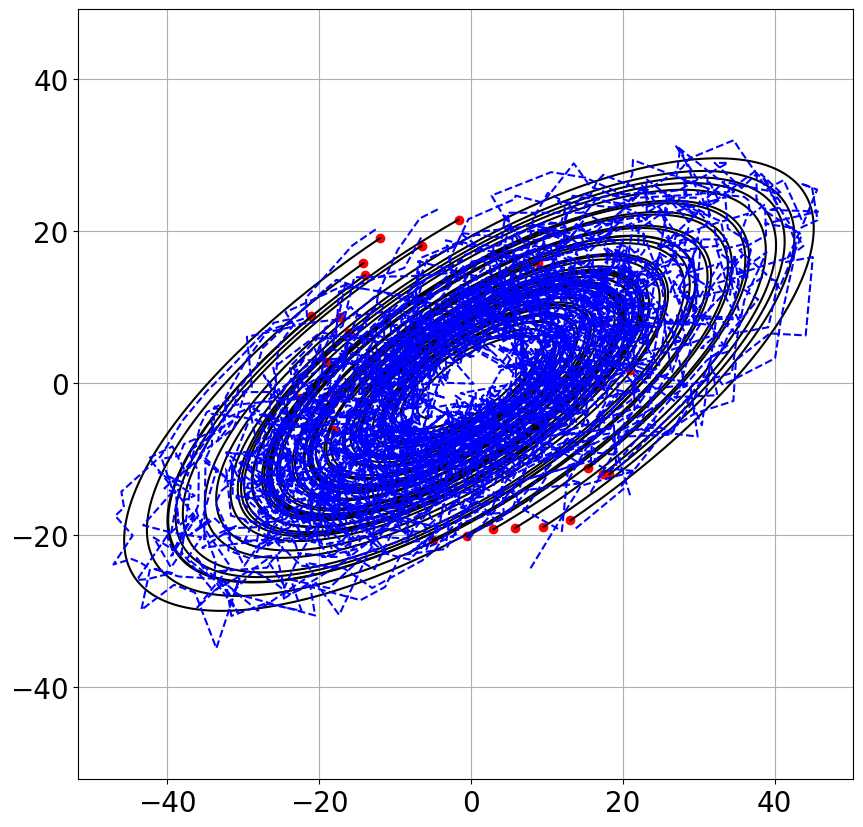

In [15]:
# PLOT ALL TRAJECTORIES

from matplotlib import patches
fig, ax = plt.subplots()

for it, (train_data, X_true, X_measure, t_measure_full) in enumerate(train_loader):
#     for i in range(args.batch_size):

#     if X_true.size()[2] == 1:
#         X_true = torch.stack((X_true, torch.zeros_like(X_true)),dim=2)
#         X_measure = torch.stack((X_measure, torch.zeros_like(X_measure)),dim=2)

    # Actual trajectory
    X_true_plt = X_true.squeeze().detach().cpu().numpy()
    plt.plot(X_true_plt.T[0],X_true_plt.T[1],'black')

    # Noisy trajectory
    traj = X_measure.detach().cpu().squeeze().numpy()
    plt.plot(traj.T[0], traj.T[1], 'b--')
    
    x0 = X_true_plt[:,0].T
    plt.scatter(x0[0],x0[1], color='red')

#     circle = patches.Circle((0,0), 17.0, edgecolor='red', facecolor='none', linewidth = 2)
#     ax.add_patch(circle)

    plt.axis('equal')
    plt.grid()
    plt.show()

Training progress...:   0%|▏                                                          | 4/1000 [00:03<14:38,  1.13it/s]

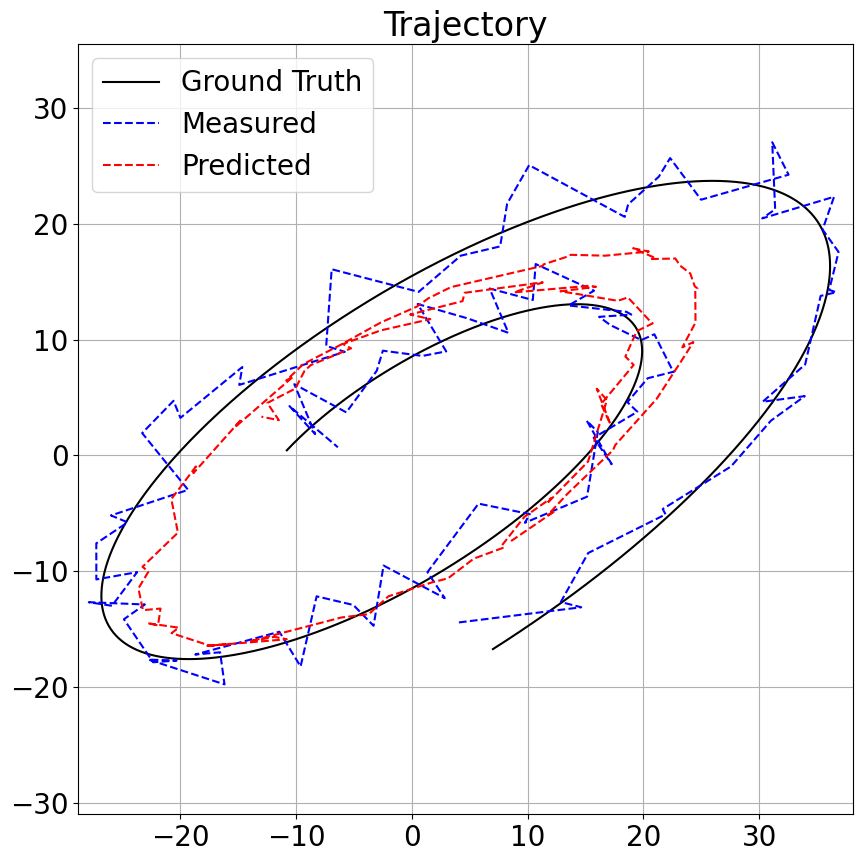

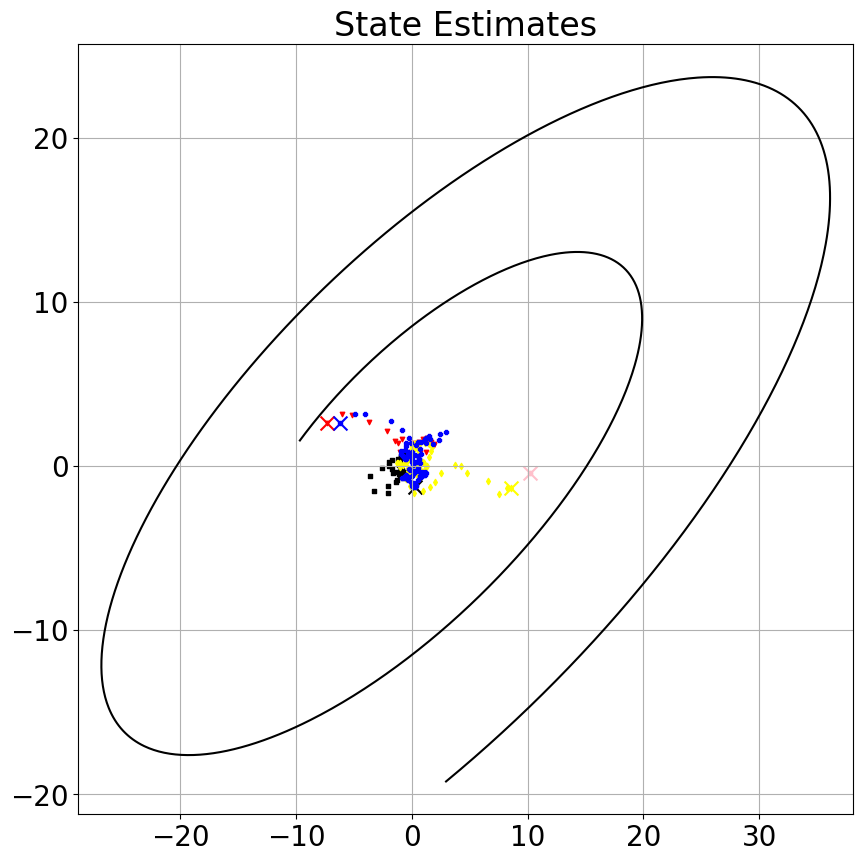

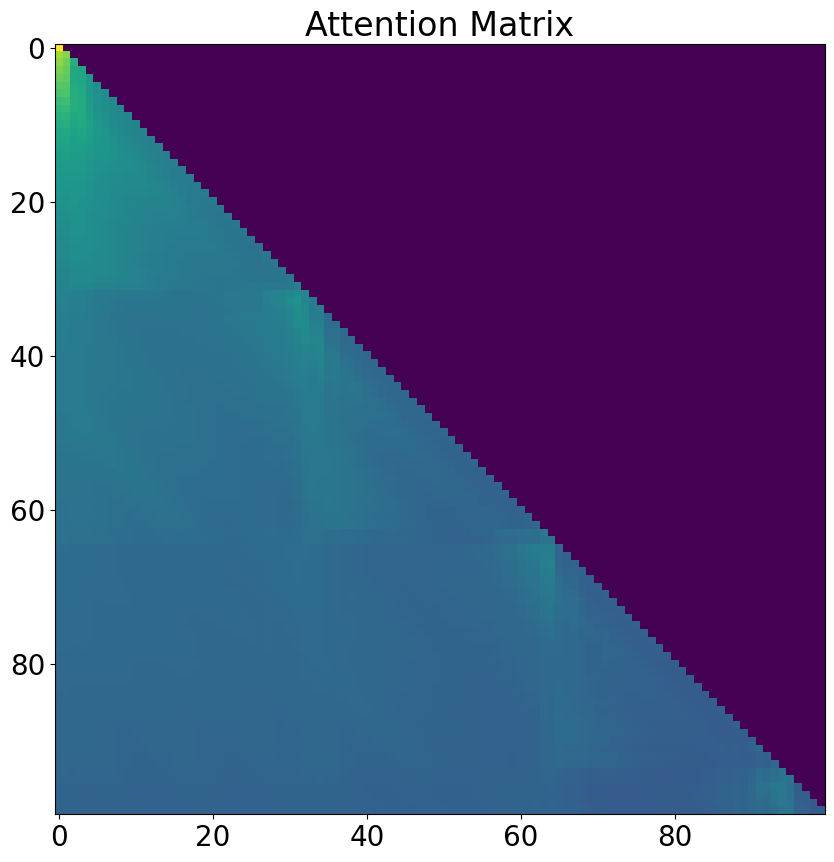

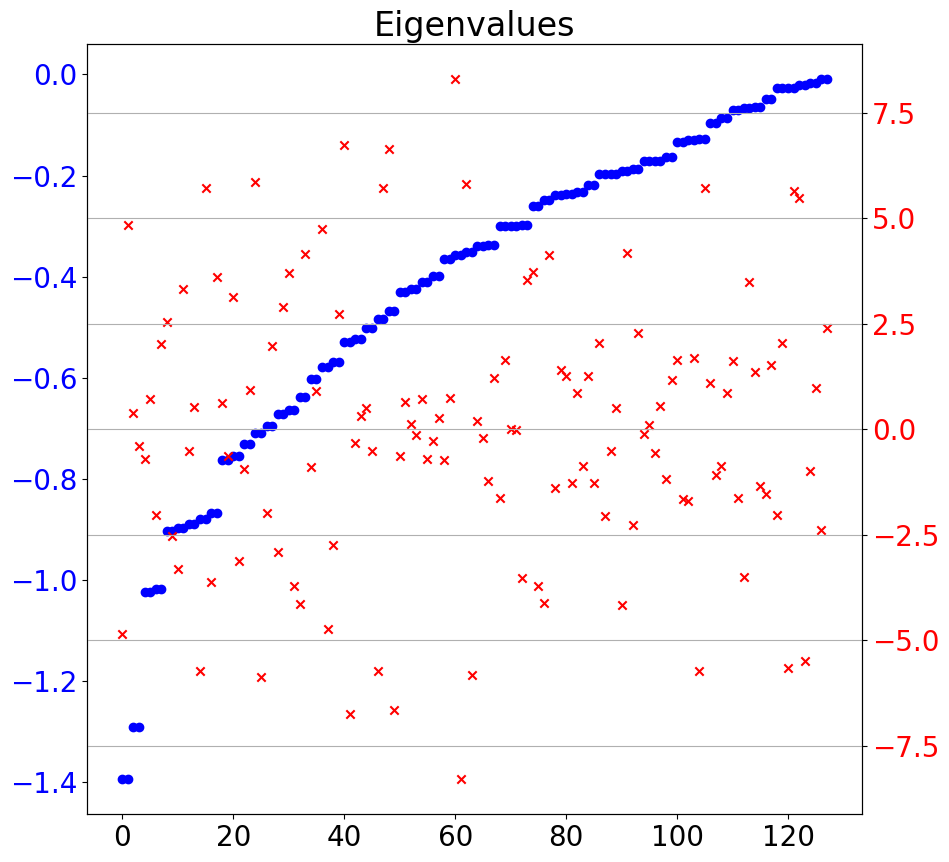

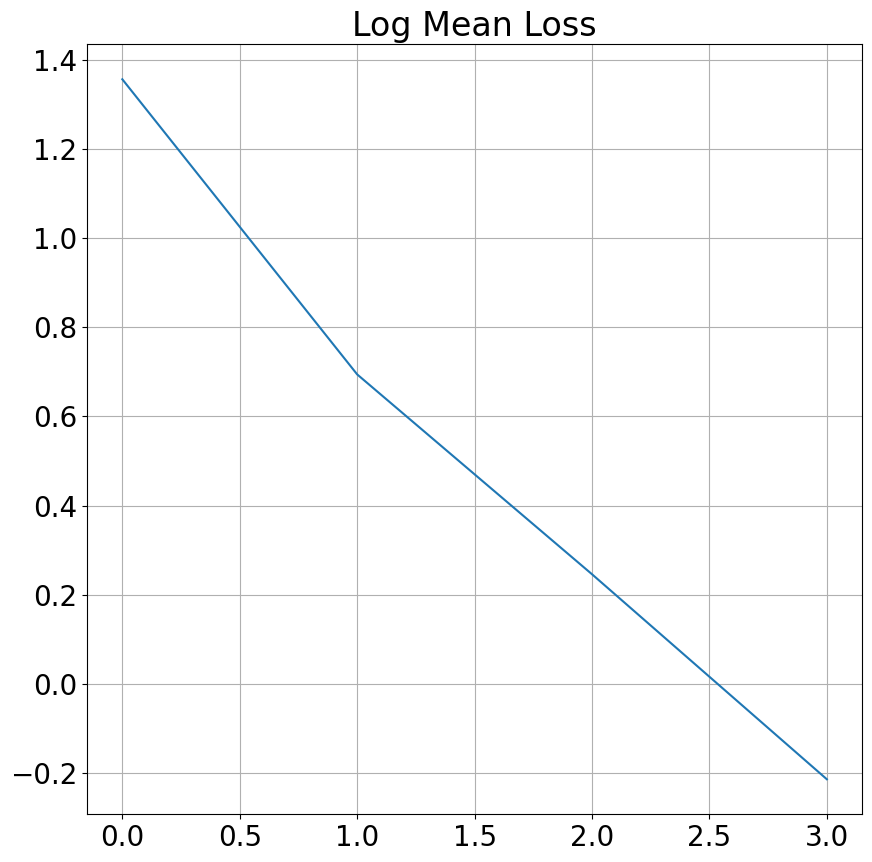

Training progress...:   0%|▎                                                          | 5/1000 [00:05<22:31,  1.36s/it]

tensor([-0.1893, -2.2763], device='cuda:0')
tensor([[-0.0687, -0.1344],
        [ 0.1841, -0.0773]])
Layer: 0 : Min grad step size =  0.4894854
Layer: 0 : Max grad step size =  0.51103044


Training progress...:   1%|▌                                                          | 9/1000 [00:09<15:15,  1.08it/s]

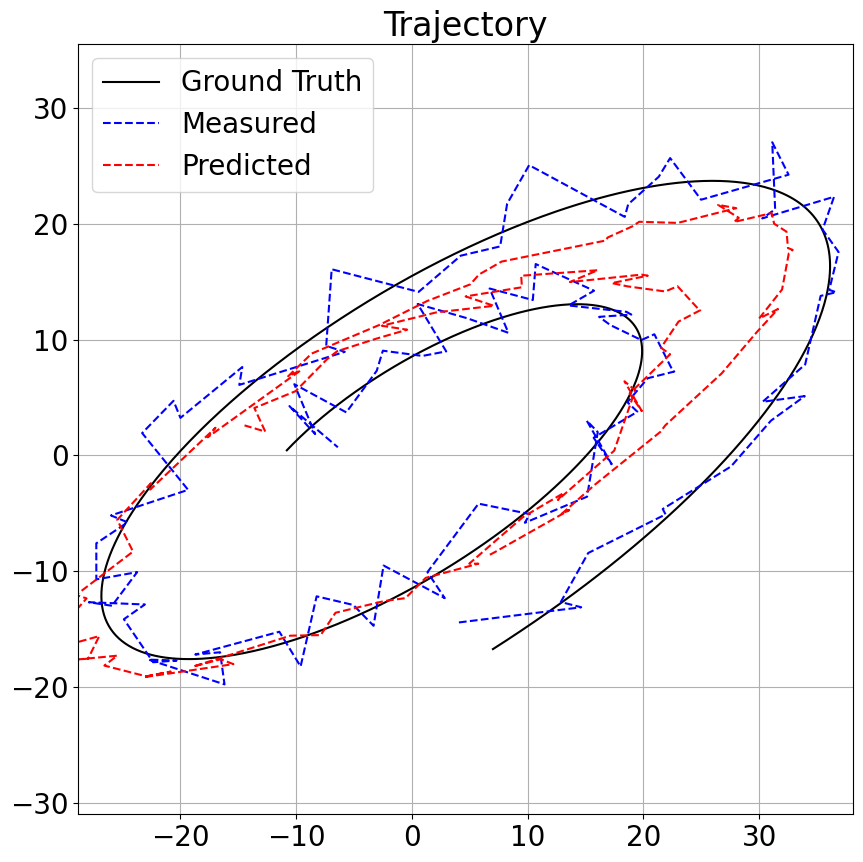

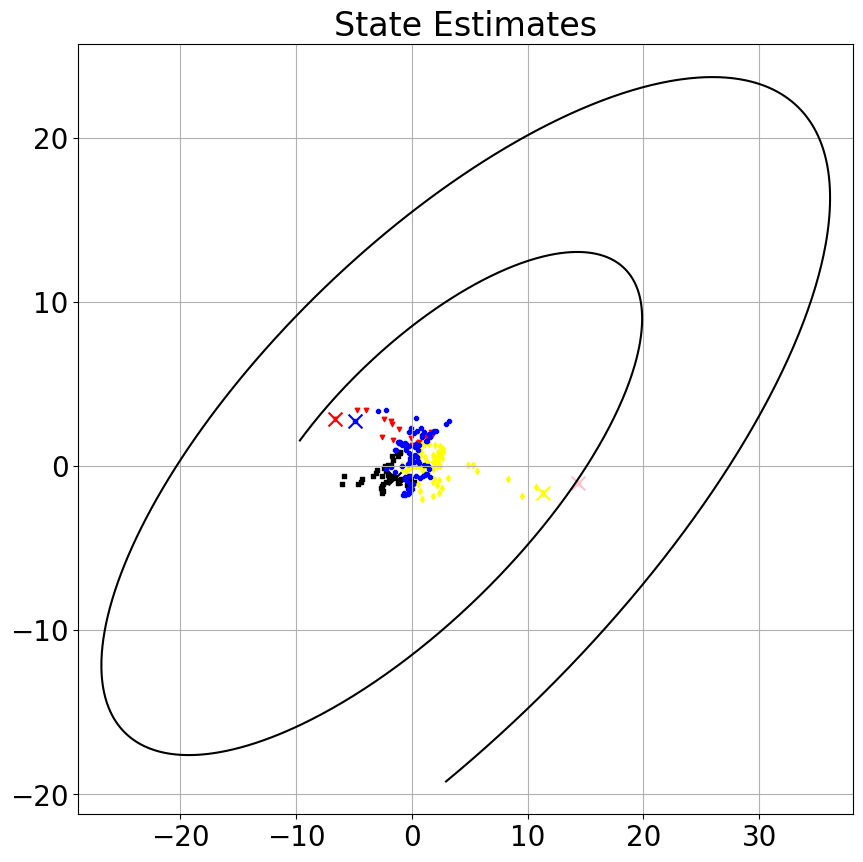

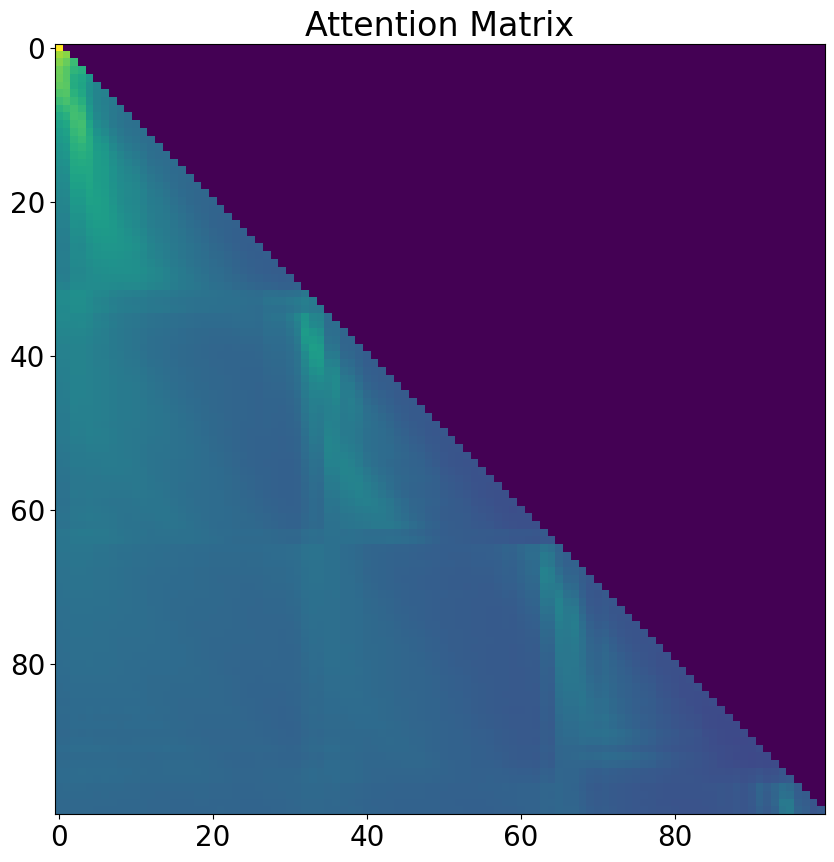

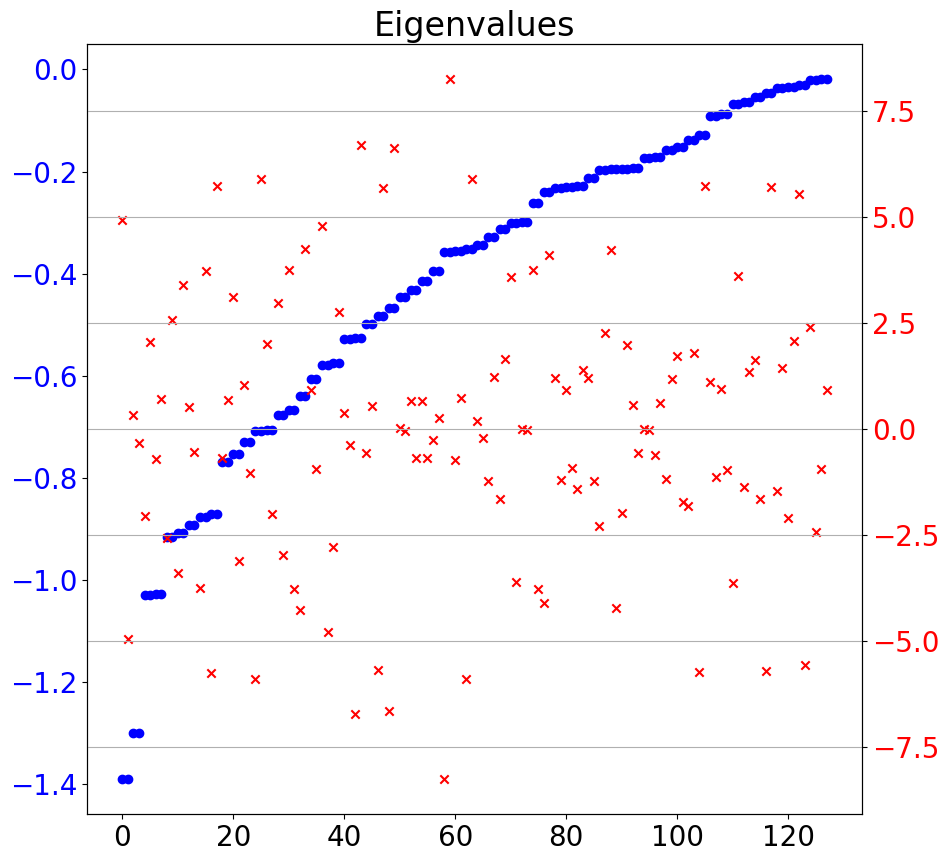

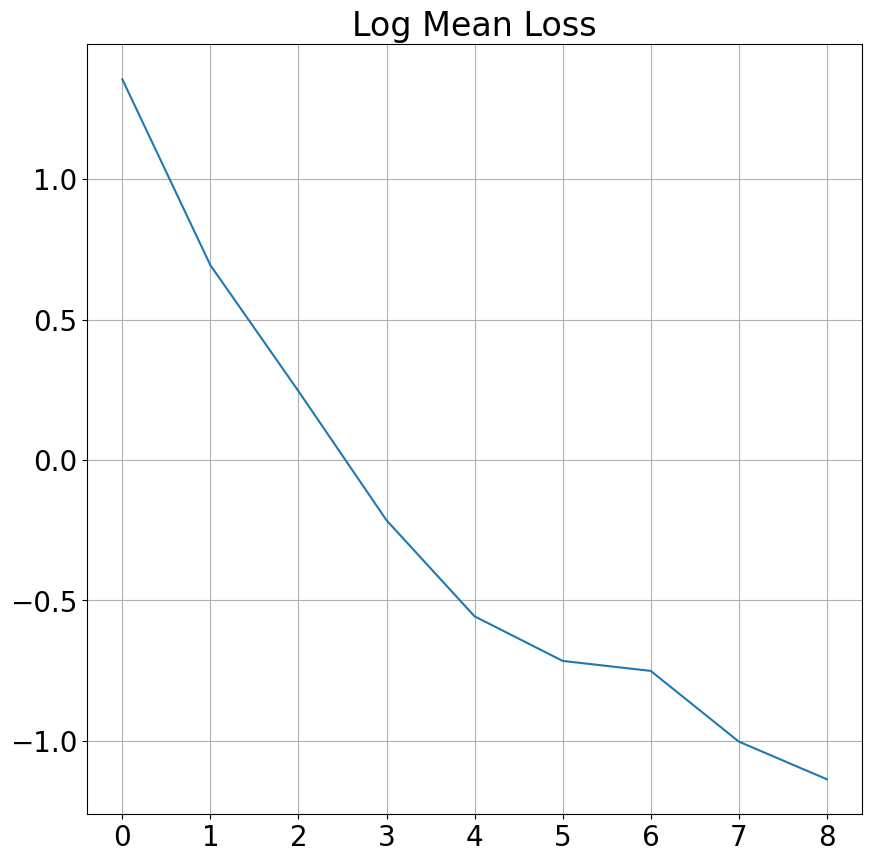

Training progress...:   1%|▌                                                         | 10/1000 [00:11<20:19,  1.23s/it]

tensor([-0.1983, -2.2652], device='cuda:0')
tensor([[-0.0567, -0.1426],
        [ 0.2369, -0.1384]])
Layer: 0 : Min grad step size =  0.486393
Layer: 0 : Max grad step size =  0.5177087


Training progress...:   1%|▊                                                         | 14/1000 [00:14<17:32,  1.07s/it]


KeyboardInterrupt: 

In [16]:
########################### TRAINING LOOP ###########################
#####################################################################

###### LOOP FOR PRECISION ATTENTION LAYERS #######

# # Initialize to correct values (for testing)
# initialize_net_to_correct_model(model, D1, S1, Si1, sigma_process, sigma_measure, args)
# for layer in model.layers:
#     initialize_net_to_correct_model(layer, D1, S1, Si1, sigma_process, sigma_measure, args)

# Train for num_epochs:
for epoch in tqdm(np.arange(args.num_epochs), desc="Training progress..."):

#     # Get training data online:
#     train_loader, train_dataset, X_true_all, X_measure_all, t_measure = create_train_loader(A, S1, Si1, Pu, Pd, R1, R1i, t_v, sigma_process, sigma_measure,args)

    # Train for single epoch
    epoch_losses, Q_ij, epoch_lambdas = single_epoch(model, train_loader, optimizer, loss, loss_p, params_list, args)

    # Collect losses
    all_losses[epoch*args.num_its:(epoch+1)*args.num_its] = epoch_losses
    mean_epoch_losses[epoch] = np.mean(epoch_losses)
    log_mean_epoch_losses[epoch] = np.log(np.mean(epoch_losses))
    all_lambdas[epoch,:,:] = np.mean(epoch_lambdas,axis=0)
    
    # Visualize results so far:
    if np.mod(epoch+1,args.show_example_epochs) == 0:
        visualize_results(model, train_dataset, all_losses, mean_epoch_losses, log_mean_epoch_losses, all_lambdas, R1, R1i, Pu, Pd, A, epoch, args)

# ##################################################
# ##### LOOP FOR REAL/COMPLEX ATTENTION NETS #######

# for epoch in tqdm(np.arange(args.num_epochs), desc="Training progress..."):

#     epoch_losses = single_epoch_attn(model, train_loader, optimizer, loss, params_list, args)
    
#     # Collect losses
#     all_losses[epoch*args.num_its:(epoch+1)*args.num_its] = epoch_losses
#     log_mean_epoch_losses[epoch] = np.log(np.mean(epoch_losses))
    
#     # Visualize results so far:
#     if np.mod(epoch+1,args.show_example_epochs) == 0:
#         visualize_results_attn(model, train_dataset, all_losses, mean_epoch_losses, log_mean_epoch_losses, all_lambdas, R1, R1i, Pu, Pd, A, epoch, args)
# ##################################################

In [ ]:
visualize_results(model, train_dataset, all_losses, mean_epoch_losses, log_mean_epoch_losses, all_lambdas, R1, R1i, Pu, Pd, A, epoch, args)

In [ ]:
for idx, layer in enumerate(model.layers):
    if hasattr(layer, 'eta_param'):
#         print('Layer:', idx, ': Mean grad step size = ', torch.mean(torch.sigmoid(layer.eta_param)).detach().cpu().numpy())
        print('Layer:', idx, ': Min grad step size = ', torch.min(torch.sigmoid(layer.eta_param)).squeeze().detach().cpu().numpy())
        print('Layer:', idx, ': Max grad step size = ', torch.max(torch.sigmoid(layer.eta_param)).squeeze().detach().cpu().numpy())
        print('Layer:', idx, ': Min grad step size = ', torch.sigmoid(layer.eta_param).squeeze().detach().cpu().numpy()[0])
        
for idx, layer in enumerate(model.layers):
    if hasattr(layer, 'noise_floor'):
        print('Layer:', idx, ': Noise floor = ', layer.noise_floor.squeeze().detach().cpu().numpy())
       

In [ ]:
inputs = inputs[:,0].unsqueeze(1)
inputs.size()
Z_q = torch.concatenate((inputs, torch.zeros_like(inputs)),dim=1)
Z_q.size()

In [ ]:
print(model.a1.noise_floor)

t_const = 10
t_scale = 1/(args.tf * t_const)
inv_softplus = np.log(np.exp(t_scale) - 1)
np.log(np.exp(inv_softplus) + 1)

In [ ]:
def count_parameters(model):
    """
    Count the number of trainable parameters in a PyTorch model.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_layers(model, layer_class):
    """
    Recursively collect all layers of a given type from a model.

    """
    return [module for module in model.modules() if isinstance(module, layer_class)]

# model
print(count_parameters(model))
# attention_layers = get_layers(model, ComplexAttentionLayer)
# attention_layers[0]

In [ ]:
epoch_losses = np.zeros(args.num_its)
epoch_lambdas = np.zeros((args.num_its,2,args.d_v))

# Iterate through training data
for it, (train_data, X_true, X_measure, t_measure_full) in enumerate(train_loader):
    break

# Outputs are one index ahead of inputs
inputs  = train_data[:, :, :-1]
outputs = train_data[:, :, 1:]

out, _ = model(inputs, t_measure_full)

loss(out.unsqueeze(-1), outputs.unsqueeze(-1))

In [ ]:
# self = model

# inputsa = self.l1(inputs)
# #         inputs = self.ReLU(inputs)
# inputsa = self.ModReLU(inputsa)

Z_q = Z_k = Z_v = inputsa

# Compute query, key, and value matrices
Q = self.a1.W_q(Z_q)
K = self.a1.W_k(Z_k)
V = self.a1.W_v(Z_v)

# Conjugate-transpose of K
Kp = K.squeeze(-1).permute(0, 1, 3, 2)  # transpose last two dims
Kp[:, 1] *= -1  # negate imaginary part

# Compute QK (complex matrix product)
QK = batched_complex_matmul_full(Q.squeeze(-1), Kp)

Q_abs = torch.sum(torch.sum(Q**2,axis=1),axis=-1).unsqueeze(-1)
K_abs = torch.sum(torch.sum(K**2,axis=1),axis=-1).unsqueeze(-2)
Q_abs + K_abs - 2 * QK[:,0]

# out1, attn = self.a1(inputsa, inputsa, inputsa)

# out1 = out1 + inputs

# out1 = self.l2(out1)
# #         out1 = self.ReLU(out1)
# out1 = self.ModReLU(out1)

# out2, attn = self.a2(out1, out1, out1)

# out2 = out2 + out1
# out2 = self.l3(out2)

In [ ]:
# # print(module.lambda1)

# # Get prediction for random choice of input
# rand_idx = np.random.choice(args.num_samp)
# train_data, X_true, X_measure, t_measure = train_dataset.__getitem__(rand_idx)
# inputs = train_data[:, :-1]
# inputs = inputs.reshape(1,100,args.d_e*2)

# out, attn = model.forward(inputs)

# plt.imshow(attn.squeeze().detach().cpu().numpy())
# plt.show()

In [ ]:
self = model.a1

for it, (train_data, X_true, X_measure, t_measure_full) in enumerate(train_loader):

    # Outputs are one index ahead of inputs
    inputs  = train_data[:, :, :-1]
    break
    
inputs.size()

t_measure_all = t_measure_full

Z_q = Z_k = Z_v = inputs

In [ ]:
lambda_h = 0 * compute_lambda_h(self.lambda1,self.args) # JUST FOR TESTING

# Take absolute value of noise parameters to ensure positive definiteness / non-negativeness
lambda_Omega = self.lambda_Omega_sqrt**2 + self.epsilon # Process noise matrix
lambda_Gamma = self.lambda_Gamma_sqrt**2 + self.epsilon # Measurement noise matrix

Q = self.W_q(Z_q).unsqueeze(-1)
K = self.W_k(Z_k).unsqueeze(-1)
V = self.W_v(Z_v).unsqueeze(-1)

if len(t_measure_all.size()) > 1:
    t_measure = t_measure_all[0,:-1]
else:
    t_measure = t_measure_all[:,:-1]

########################################################

K_exp, K_exp2, _, _ = compute_exp_kernel(lambda_h, t_measure)
X_ij_hat_all, R_qk_ij = batched_compute_estimates_and_residuals_vectorized(Q, K, V, K_exp, self.args)
mat_exp = K_exp[:, -(self.args.seq_len+1), :, :] # Get matrix exponential for next-state prediction
K_cov = compute_covariance_kernel(lambda_h, lambda_Omega, lambda_Gamma, K_exp, t_measure, self.args, lambda_C=self.lambda_C)

V_ij =  build_covariance_from_kernel(K_cov, self.args)

# Compute unnormalized attention matrix
mahalanobis_distance = (R_qk_ij[:,0]**2 + R_qk_ij[:,1]**2) / (V_ij + lambda_Gamma)

dist_sum = (self.nu**2 / self.d_k) * torch.sum(mahalanobis_distance, axis=3, keepdims = True)

base_attn_scores = V_ij * (1 + dist_sum)
base_attn_scores = torch.clamp(base_attn_scores, min=1e-30, max=1e30)
attention_scores = - self.tau**2 * torch.log(base_attn_scores)

attention_scores.size()

In [ ]:
# lambda_h = compute_lambda_h(self.lambda1,self.args) # Get nonpositive complex conjugate eigenvalues
lambda_h = 0 * compute_lambda_h(self.lambda1,self.args) # JUST FOR TESTING

# Take absolute value of noise parameters to ensure positive definiteness / non-negativeness
lambda_Omega = self.lambda_Omega_sqrt**2 + self.epsilon # Process noise matrix
lambda_Gamma = self.lambda_Gamma_sqrt**2 + self.epsilon # Measurement noise matrix

# Project input into Q, K, V        
Q = self.W_q(Z_q).unsqueeze(-1)
K = self.W_k(Z_k).unsqueeze(-1)
V = self.W_v(Z_v).unsqueeze(-1)

if len(t_measure_all.size()) > 1:
    t_measure = t_measure_all[0,:-1]
else:
    t_measure = t_measure_all[:,:-1]

########################################################

K_exp, K_exp2, exp_f, exp_b = compute_exp_kernel(lambda_h, t_measure)

mat_exp = K_exp[:, -(self.args.seq_len+1), :, :] # Get matrix exponential for next-state prediction

K_cov = compute_covariance_kernel(lambda_h, lambda_Omega, lambda_Gamma, K_exp, t_measure, self.args, lambda_C=self.lambda_C)

V_avg_ij = build_avg_covariance_from_kernel(K_cov, args).squeeze()

V_k, V_v, U_q, U_k, U_v = build_factorized_kernels(exp_f, exp_b, exp_f, exp_b, Q, K, V)

R_qk_abs = compute_weighted_residual_norm(V_k, U_k, U_q)

base_attn_scores = V_avg_ij + R_qk_abs

attention_scores = - self.tau**2 * torch.log(base_attn_scores).unsqueeze(-1).unsqueeze(-1)

attention_scores.masked_fill_(self.causal_mask == 0, float('-inf')) # Set to -infinity where mask is 0
attention_scores_normalized = torch.softmax(attention_scores, dim=2)

# Complex-valued attention matrix
Q_ij = torch.stack((attention_scores_normalized, torch.zeros_like(attention_scores_normalized)),dim=1) # Add zero imaginary part to unnormalized attention

# Estimate in diagonalized space
est_inner = batched_complex_matmul_full(Q_ij.squeeze(-1).squeeze(-1), U_v).unsqueeze(-1) # Multiply by Values to get output

est_v = V_v.unsqueeze(-1) * est_inner

# Add residual connection
# est_eigenbasis = est_v # No residual connection
est_eigenbasis = (1-torch.sigmoid(self.delta))*V + torch.sigmoid(self.delta)*est_v

# Get prediction in diagonalized space
pred_p = batched_complex_hadamard(mat_exp, est_eigenbasis)

# Multiply by output matrix to get output prediction
pred = self.W_p(pred_p.squeeze(-1))
#     pred = batched_complex_matmul(self.W_p, batched_complex_hadamard(lambda_h, X_v))*self.args.dt + X_v # JUST FOR TESTING

# Output is a linear combination of estimate and prediction
out = pred

X_ij_hat_all = V_v.unsqueeze(3) * U_v.unsqueeze(2) # We only form this m^2 d tensor for visualization/testing

out.size()

In [ ]:
print(V_v.size())
U_v.size()

X_ij_hat_all = V_v.unsqueeze(3) * U_v.unsqueeze(2)
